# Ten intensities — A bigger data set

Now we're going to load an even larger data set. The `ten_intensities` data set expands on the optogenetic spike train data we worked with in the previous chapter. Now we have data recorded from a neuron as it was stimulated with ten different intensities of the light that activates its receptors (550 nm green). We have 10 trials' worth of data at each intensity, so 100 trials in total. Each trial was 20 ms long, with optical stimulation starting at 5 ms and ending at 15 ms. Measuring the neuron's response across a range of intensities allows us to map out the response "profile" of the neuron in terms of the number of spikes elicited by differing intensities. 

In [158]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

stim_on = 4  # time stimulus turned on
stim_off = 14 # time stimulus turned off

## Read the data

First we load the data. The syntax here is different from what we've used to read CSV files into pandas, but it works for pickles.

In [130]:
spikes = pd.read_csv('data/ten_intensities.csv')

## Figure out the structure of the data

When first starting to work with a data set, you need to explore it and understand how it's structured. What variable type(s) are in it? How are different experimental conditions coded? Sometimes you know this, if you created the data, but often you only have a general idea of what's in a data file, and you need to inspect it to figure out the details. 

If we look at the `head` of the data, we can see that there are columns for intensitiy level and trial number, and then a series of numbered columns. Those are the times in milliseconds from the start of each trial, and each row for these columns has a `1` if there was a spike at that time, or a `0` otherwise:

In [111]:
spikes.sample(25)

,Intensity,Trial,SpikeTime
9,1,2,20
51,5,3,10
0,0,1,14
80,6,4,8
45,5,0,15
120,7,3,11
12,1,8,15
58,5,7,10
118,7,2,19
181,8,7,17


We can view the shape of the matrix to see how much data we have. Recall that `.shape` is a property of a DataFrame object, not a method, so we don't put parentheses after it.

In [112]:
spikes.shape

(231, 3)

### Data format

This data set doesn't look like the previous spike trains we saw: rather than zeros and ones, we have a column of spike times. This is called a **sparse** representation of the data, and it is a much more efficient way of representing spike trains than the way we saw in the previous lesson. This is because spikes are relatively rare, occurring only a few times at most on each trial. So if we represent the data by having a vale for each time point on every trial, we have a lot of data points that are filled with zeros, and really tell us nothing. If our data only represent when the ones are, we can infer that the rest of the data points are zero, but we end up storing much less data. This makes working with the data faster, especially with very large data sets. 

In the `spikes` DataFrame, the first column encodes the intensity level:


In [113]:
spikes['Intensity'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

The `Trial` column encodes trial number (nested in intensity levels):

In [114]:
spikes['Trial'].unique()

array([1, 3, 4, 5, 6, 0, 2, 8, 9, 7])

And, as you might expect, `SpikeTimes` contains the times at which spike occurred. 


### Index the DataFrame

This is wide-format data, with two variables, `Intensity` and `Trial` as single columns encoding multiple levels, and the time variable as a set of 21 columns. As we saw with the Gapminder data set, it makes sense to make the first two columns indexes for the DataFrame, so that all of the (non-index) columns represent levels of the same variable (time). Since we are specifying two rows as indexes, they need to be passed as a list so that, collectively, they comprise the first argument to `.set_index()`:

In [115]:
# spikes = spikes.set_index(['Intensity', 'Trial'])

Now when we look at the first 12 rows, we see our two index columns on the left in boldface, and that our indexes are **nested**, reflecting the structure of our data: trials are nested within intensity levels:

In [131]:
spikes.head(12)

,Intensity,Trial,SpikeTime
0,0,1,14
1,0,1,18
2,0,3,14
3,0,3,20
4,0,4,14
5,0,5,18
6,0,6,13
7,1,0,17
8,1,1,13
9,1,2,20


## Visualizing the Data

### Raster plot
We'd like to visualize this larger data set using raster plots and PSTHs, as we did for the previous data. To do this, we'll need to consider how to show the different responses for each each intensity level. There are a few ways we could do this, but here we'll do it by adding more subplots, expanding on how we drew the raster plot and PSTH in the same figure in the previous page.

Here we'll build the code up in stages, first getting one plot working (a raster of one intensity level) and then adding the PSTH for that level, then plotting all the levels of intensity in different subplots, in a loop. We'll start with the highest intensity level (`9`) as our "test case" because we can expect that it will elicit the most intense responses. 

The code below is very similar to what we used in the previous lesson, except that we're selecting subsets of data from a DataFrame:

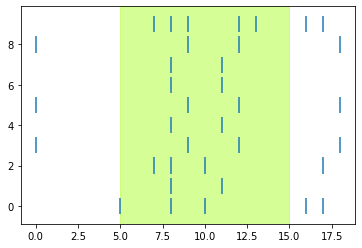

In [147]:
fig, ax = plt.subplots()

# Shade time when stimulus was on
plt.axvspan(stim_on, stim_off, alpha=0.5, color='greenyellow')

# select just data for intensity level 9
dat = spikes[spikes['Intensity'] == 9]

# Draw the raster one trial at a time
for trial in dat['Trial'].unique():
    # get spike times for this trial
    spike_times = dat[dat['Trial'] == trial]['SpikeTime']
    # Draw the raster
    ax.vlines(spike_times, 
              trial - 0.4, trial + 0.4)

plt.show()

### PSTH 

Now we can draw a PSTH for this intensity level. We're going to draw this differently from before, using Matplotlib's built-in `.hist()` method:

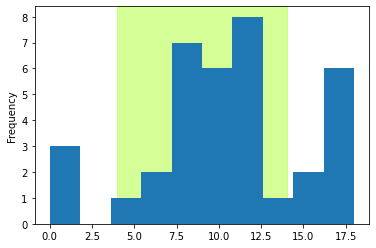

In [161]:
fig, ax = plt.subplots()

# Shade time when stimulus was on
plt.axvspan(stim_on, stim_off, alpha=0.5, color='greenyellow')

dat['SpikeTime'].plot(kind='hist')

plt.show()

### Combine raster and PSTH

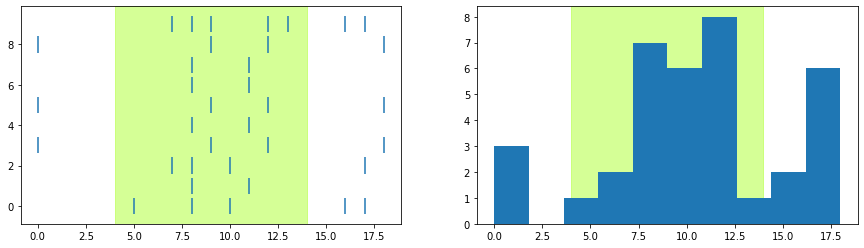

In [159]:
# here we hard-code the figure dimensions (x, y) to control the way the plot looks
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Shade time when stimulus was on
axs[0].axvspan(stim_on, stim_off, alpha=0.5, color='greenyellow')

# select just data for intensity level 9
dat = spikes[spikes['Intensity'] == 9]

# Draw the raster one trial at a time
for trial in dat['Trial'].unique():
    # get spike times for this trial
    spike_times = dat[dat['Trial'] == trial]['SpikeTime']
    # Draw the raster
    axs[0].vlines(spike_times, 
              trial - 0.4, trial + 0.4)

    
# Shade time when stimulus was on
axs[1].axvspan(stim_on, stim_off, alpha=0.5, color='greenyellow')
axs[1].hist(dat['SpikeTime'])

plt.show()

### Looping Through Intensity Levels

Now we can embed the plot commands above into a loop through all intensity levels. We'll plot each raster and PSTH as a row in a figure with 10 rows (intensity levels) and 2 columns. This will involve using more variables and indexing.

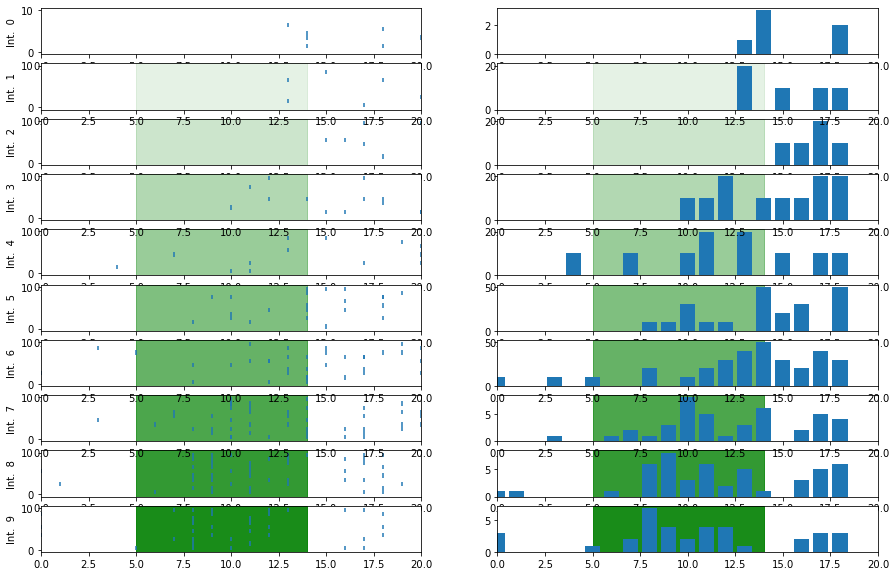

In [14]:
fig = plt.figure(figsize=[15, 10])

# Rather than hard-coding the number of intensities, we derive the number of levels 
#   from the structure of the data. This ensures that our code is robust if we later 
#   want to use it with different-sized data sets. 
num_intensities = len(ten_intensities)

# Now we loop through the ten_intensities dictionary, indexing it by the keys
for key in ten_intensities.keys():

    # Raster plots
    
    # The line below sets the subplot in which to graph the data from a particular 
    # intensity level. Although dictionaries are not ordered, the resulting plot has the 
    # intensities ordered from lowest to highest. This works because the dictionary keys
    # in this case start with the intensity levels, as numerals. The third argument to 
    # plot_subplot - which specifies which plot we're drawing into - is obtained by slicing
    # the name of the key to extract the first character (the number) and converting it from
    # a string to a number (int). 
    
    # Another thing to note is that the rows are selected by mutiplying the intensity 
    # levels by two, then adding one. The +1 is because (in an exception to what is typical 
    # in Python) matplotlib figure subplots are numbered from 1 rather than zero. So intensity 
    # level 0 goes in row 1 of the plot. Mutiplying by 2 is because we have two columns 
    # in the plot, and the subplots are numbered sequentially (i.e., subplot 2 is first 
    # row, second column, subplot 3 is first column second row, etc.). It's worth taking the 
    # time to think through the math for this, as it can be quite effective and flexible.

    ax = plt.subplot(num_intensities, 2, int(key[0]) * 2 + 1)
 
    # Plot the raster
    for trial in range(10): 
        plt.vlines(ten_intensities[key][trial], trial, trial + 1)

    # Each trial was 20 s long, but the maximum latency (time of last spike) on each trial 
    # may be less than 20. We hard-code the length of the x axis so that across the different 
    # intensitiy levels, the x axis is always exactly 20 s long.
    plt.xlim([0, 20])
    
    # Label the y axis with the intensity level
    plt.ylabel('Int.  ' + str(key[0]), fontsize=10)
    
    # The line below sets the intensity of the green shading (indicating when the stimulus
    # was on) according to the intensity of the stimulus. This is done using the alpha 
    # argument to plt.axvspan. Alpha sets the transparency of a visual element, over a 
    # range from 0 (transparent) to 1 (opaque). So by multiplying by 0.1 we turn the 
    # intensity values (which range from 0 to 9) into acceptable alpha values.
    plt.axvspan(5, 14, alpha=0.1*float(key[0]), color='g')
          
    # PSTHs    
    # Specify the subplot for the second column in the row for this intensity
    ax = plt.subplot(num_intensities, 2, int(key[0]) * 2 + 2)
    
    # add shading proportional to the intesity
    plt.axvspan(5, 14, alpha=0.1*float(key[0]), color='g')
    
    # Generate one long list of all the values (since for a histogram we don't 
    # care which trial the data came from, we want to collapse over the trials)
    spike_times = [a for b in ten_intensities[key] for a in b] 
    
    # Make a histogram of the values. The range(20) argument ignores any data 
    # from time points past 20 s. Don't draw the histogram but return it as two variables. 
    spike_count, bins = np.histogram(spike_times, bins=range(20))
    
    # Draw the histogram with bins on the x axis and bar height as the y axis:
    plt.bar(bins[:-1], spike_count)

    plt.xlim([0, 20])
        
plt.show();

### Making it Pretty

This shows us the data, but it's pretty messy-looking. In particular, the plots overlap with other plots' axis labels, and those are redundant anyway - we can just put the times on the bottom of the plot since they're the same for all plots. We can also add more labels to help make the plot more interpretable by others.

Another thing we'll do below is convert all the histograms from showing the raw number of spikes, to the probability of spiking (percentage of trials that a spike occurred at that time), which will help standardize the y axis of the histograms (i.e., all plots will be on the same scale). To help with this, note the third line of code in the cell below, which sets the number of trials. Then when we get to the `plot.bar()` command, we divide the `spike_count` by the number of trials. 

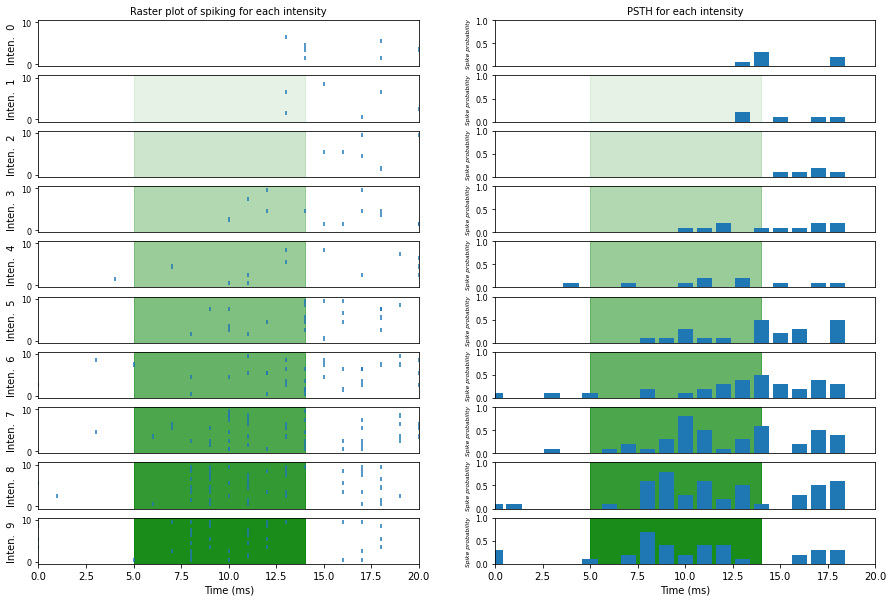

In [15]:
fig = plt.figure(figsize=[15, 10])
num_intensities = len(ten_intensities)
num_trials = 10

for key in ten_intensities.keys():

    # Raster plots
    # The line below sets the subplot in which to graph the data from a particular 
    # intensity level. Although dictionaries are not ordered, the resulting plot has the 
    # intensities ordered from lowest to highest. This works because the dictionary keys
    # in this case are the intensity levels, as numerals. So when we select the first 
    # character in the key (key[0]) and convert it to float, Python will select the 
    # approriate row of the figure to plot the data in. 
    # Another thing to note is that the rows are selected by mutiplying the intensity 
    # levels by two, then adding one. The +1 is because, in an exception to what is typical 
    # in Python, figure subplots are numbered from 1 rather than zero. So intensity 
    # level 0 goes in row 1 of the plot. Mutiplying by 2 is because we have two columns 
    # in the plot, and the subplots are numbered sequentially (i.e., subplot 2 is first 
    # row, second column, subplot 3 is first column second row, etc.)

    ax = plt.subplot(num_intensities, 2, int(key[0]) * 2 + 1)
 
    for trial in range(10): 
        plt.vlines(ten_intensities[key][trial], trial, trial + 1)
    plt.xlim([0, 20])
    plt.ylabel('Inten.  ' + str(key[0]), fontsize=10)
    plt.yticks(fontsize=8)
    
    # The line below sets the intensity of the green shading (indicating when the stimulus
    # was on) according to the intensity of the stimulus. This is done using the alpha 
    # argument to plt.axvspan. Alpha sets the transparency of a visual element, over a 
    # range from 0 (transparent) to 1 (opaque). So by multiplying by 0.1 we turn the 
    # intensity values (which range from 0 to 9) into acceptable alpha values.
    plt.axvspan(5, 14, alpha=0.1*float(key[0]), color='g')
    
    # Place x ticks and x label only below bottom row of plots:    
    if float(key[0]) < 9:
        plt.xlabel('')
        plt.xticks([])
    else:
        plt.xlabel('Time (ms)')
        
    # Add title only above top row (intensity 0):
    if float(key[0]) == 0:
        plt.title('Raster plot of spiking for each intensity',fontsize=10)
        
    # PSTHs    
    ax=plt.subplot(num_intensities, 2, int(key[0]) * 2 + 2)
    plt.axvspan(5, 14, alpha=0.1*float(key[0]), color='g')
    
    # Next line is an interesting list comprehension that takes the list of lists, 
    # and outputs one long list of all the values (since for a histogram we don't 
    # care which trial the data came from, we want to collapse over the trials)
    spike_times = [a for b in ten_intensities[key] for a in b] 
    
    # Make a histogram of the values. The range(20) argument ignores any data 
    # from time points past 20 s. Don't draw the histogram but return it as two variables. 
    # According to its API, np.histogram returns the values of the histogram as an array, 
    # and the bin edges
    spike_count, bins = np.histogram(spike_times, bins=range(20))
    
    # Compute probability for the histogram by dividing spike_count by number of trials
    plt.bar(bins[:-1], spike_count / num_trials)
    plt.xlim([0, 20])
    plt.ylim([0, 1])
    plt.yticks(fontsize=8)
    plt.ylabel('Spike probability', style='italic', fontsize = 6)

    # place title only above the first row of plots:
    if float(key[0]) == 0:
        plt.title('PSTH for each intensity', fontsize=10)
        
    # Place x ticks and x label only below bottom row of plots:    
    if float(key[0]) < num_intensities-1:
        plt.xlabel('')
        plt.xticks([])
    else:
        plt.xlabel('Time (ms)')
        
plt.show();

### Nested list comprehension

I commented on it above, but this line is interesting and warrants deeper understanding:

    [a for b in ten_intensities[key] for a in b] 

This is **nested list comprehension**, which applies list comprehension to lists of lists. As noted earlier, each entry in the `ten_intensities` dictionary is a list containing 10 lists, one for each trial:

In [16]:
ten_intensities['0_intensity']

[[83.0, 41.0],
 [14.0, 87.0, 18.0, 84.0],
 [24.0, 51.0, 66.0, 86.0, 96.0],
 [26.0, 14.0, 51.0, 20.0, 50.0, 23.0],
 [14.0, 27.0, 60.0, 45.0, 56.0, 58.0, 60.0],
 [48.0, 18.0, 40.0, 43.0],
 [13.0, 46.0, 47.0, 90.0],
 [33.0, 61.0, 55.0, 64.0, 56.0],
 [72.0, 64.0, 45.0, 82.0],
 [34.0, 74.0, 71.0, 53.0]]

In its simplest form, as used here, nested list comprehension is a way to convert a list of lists to one long list.

The syntax probably looks confusing, to say the least! But it's relatively simple once you learn to read it. In the code

    [a for b in ten_intensities[key] for a in b] 

`b` stands for each item (list) in the list of lists, and `a` stands for the individual items within `b`. For example, in `ten_intensities['0_intensity']` as shown above, for the first item `b` would be `[83.0, 41.0]` and `a` would be `83.0` and `41.0`. So we could read this as "Return `a` (values) for `b` (lists) in ten_intensities[key] (list of lists) for all items (`a`) in each list (`b`)". Since there are square brackets around the entire expression, the result is a list of all these values.

As we see below, if we run this nested list comprehension on the `0_intensity` dictionary values, we get one long list with all the values from the list of lists above, sequentially:

In [17]:
[a for b in ten_intensities['0_intensity'] for a in b] 

[83.0,
 41.0,
 14.0,
 87.0,
 18.0,
 84.0,
 24.0,
 51.0,
 66.0,
 86.0,
 96.0,
 26.0,
 14.0,
 51.0,
 20.0,
 50.0,
 23.0,
 14.0,
 27.0,
 60.0,
 45.0,
 56.0,
 58.0,
 60.0,
 48.0,
 18.0,
 40.0,
 43.0,
 13.0,
 46.0,
 47.0,
 90.0,
 33.0,
 61.0,
 55.0,
 64.0,
 56.0,
 72.0,
 64.0,
 45.0,
 82.0,
 34.0,
 74.0,
 71.0,
 53.0]

For a nice tutorial on list comprehension, culminating in nested list comprehension, check out [this DataCamp article](https://www.datacamp.com/community/tutorials/python-list-comprehension).